# Cities of Summer

This started out as a classroom exercise for a General Assembly introductory programming course, and
each year I take a look at it and make some changes.

So let's look at how much of the year is winter, and how much is summer.

In [1]:
import pandas as pd
import matplotlib
import io
%matplotlib inline
import seaborn
seaborn.set(style="whitegrid")

In [2]:
last_full_year = 2018

In [3]:
def get_temperature_ranges(city_max_name, city_min_name):
    import zipfile
    z1 = zipfile.ZipFile(city_max_name + '.zip')
    z2 = zipfile.ZipFile(city_min_name + '.zip')

    maximums = pd.read_csv(io.BytesIO(z1.read(city_max_name + '_Data.csv')), parse_dates=[['Year','Month','Day']])
    minimums = pd.read_csv(io.BytesIO(z2.read(city_min_name + '_Data.csv')), parse_dates=[['Year','Month','Day']])

    maximums.columns = ['Date','Code','Station','Max','Accum','Quality']
    just_maximums = maximums[['Date','Max']]
    minimums.columns = ['Date','Code','Station','Min','Accum','Quality']
    just_minimums = minimums[['Date','Min']]
    temperatures = just_minimums[['Date', 'Min']].merge(
                   just_maximums[['Date', 'Max']],
        left_on='Date',
        right_on="Date"
    )
    temperatures['Year'] = temperatures.Date.dt.year
    return temperatures

To explain that -- we read the data we downloaded from the Bureau. Then we extracted the data files
(there's are boring note files in there as well). Each data file has 8 columns, but we smashed Year, Month and
Day together into one, leaving us with 6 columns.

Only columns 1 and 4 are interesting (the date and the temperature). We merged this data from the two files
together (temperatures) keying off the date in them.

Then we added a column for the year number, because we'll need that and it was easy to derive it.

In [4]:
def get_cold_and_hot_days(temperatures, threshold):
    threshold_str = str(threshold)
    extremes = pd.DataFrame({
        'minimum_above_' + threshold_str:
           temperatures[(temperatures.Min > threshold) & (temperatures.Year <= last_full_year)
                       ].groupby('Year').Min.count().fillna(0),
        'maximum_below_' + threshold_str: 
           temperatures[(temperatures.Max < threshold) & (temperatures.Year <= last_full_year)
                       ].groupby('Year').Max.count().fillna(0)
    }).fillna(0)
    return extremes

This is a bit simpler -- we are just creating a year-by-year analysis counting the number of days above
and below 20.

## Sydney

Sydney temperatures from the Sydney observatory (station code 066062):

- Maximum temperatures downloaded from http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_display_type=dailyZippedDataFile&p_stn_num=066062&p_c=-873070771&p_nccObsCode=122&p_startYear=2018

- Minimum temperatures downloaded from http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_display_type=dailyZippedDataFile&p_stn_num=066062&p_c=-873070967&p_nccObsCode=123&p_startYear=2018

The URL seems to change each time I request it, so I need to be a bit smarter about automating that bit.

### How hot?

It "feels like" winter when the maximum temperature is below 20. It means you have the heater on
(or it means I need to light a fire). It feels like summer when the minimum temperature is above 20; 
you have to sleep with at least a fan and you can dive into the pool or sea any time of the data or
night and it isn't uncomfortable.

In [5]:
SYDNEY_MAX = 'IDCJAC0010_066062_1800'
SYDNEY_MIN = 'IDCJAC0011_066062_1800'

sydney_temperatures = get_temperature_ranges(SYDNEY_MAX, SYDNEY_MIN)
sydney_extremes = get_cold_and_hot_days(sydney_temperatures, 20)

I was born in 1972, and my mother said that being pregnant with me that summer was awful, and the summer at the
beginning of 1973 was terrible. We spent a lot of time in the pool that summer.

So let's look at 1972 and 1973, 50 years ago and 100 years ago, and the most recent few years.


In [6]:
sydney_extremes.loc[sydney_extremes.index.isin([1972,1973, last_full_year-50, last_full_year-100, 1859,
                                         last_full_year, last_full_year-1, last_full_year-2])]

,minimum_above_20,maximum_below_20
Year,,
1859,1,146
1918,7,127
1968,41,120
1972,21,119
1973,48,109
2016,70,79
2017,81,87
2018,61,98


So yes, she wasn't wrong -- 1973 was pretty incredible. It's just that 2018 (which was pretty mild) was even worse.

Let's just put that in perspective. 100 years ago, sweltering days where the temperature never got below
20 were really rare. Here's the complete list of them...

In [7]:
sydney_temperatures[(sydney_temperatures.Min > 20) & (sydney_temperatures.Year == last_full_year-100)].set_index('Date')

,Min,Max,Year
Date,,,
1918-01-15,20.6,25.8,1918
1918-01-22,20.6,26.7,1918
1918-01-25,20.1,26.2,1918
1918-02-04,21.6,27.2,1918
1918-02-10,21.1,24.9,1918
1918-02-12,20.8,27.3,1918
1918-03-05,20.5,26.9,1918


So is there a trend? Here's a chart since records began:

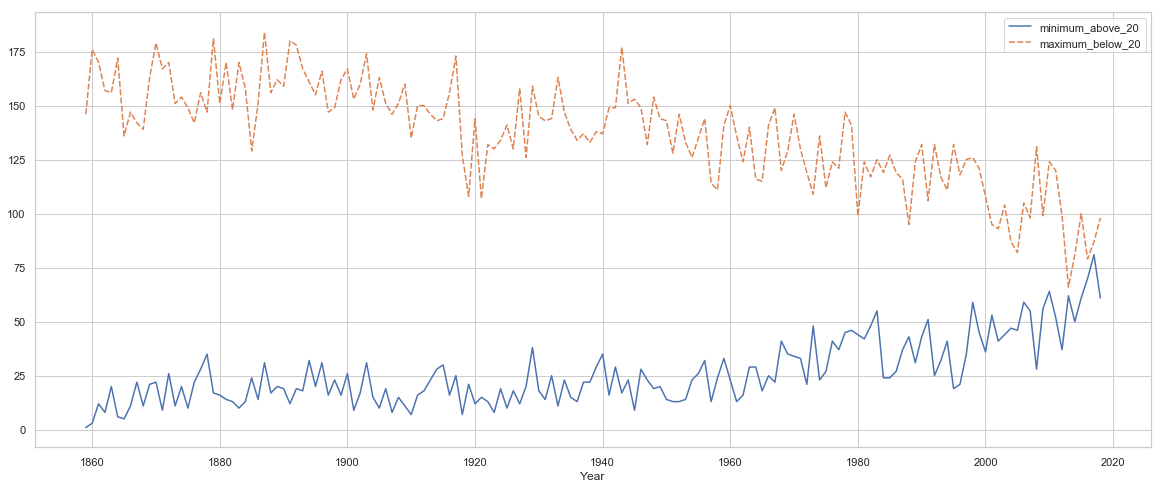

In [8]:
matplotlib.pyplot.figure(figsize=(20,8))
seaborn.lineplot(data=sydney_extremes)

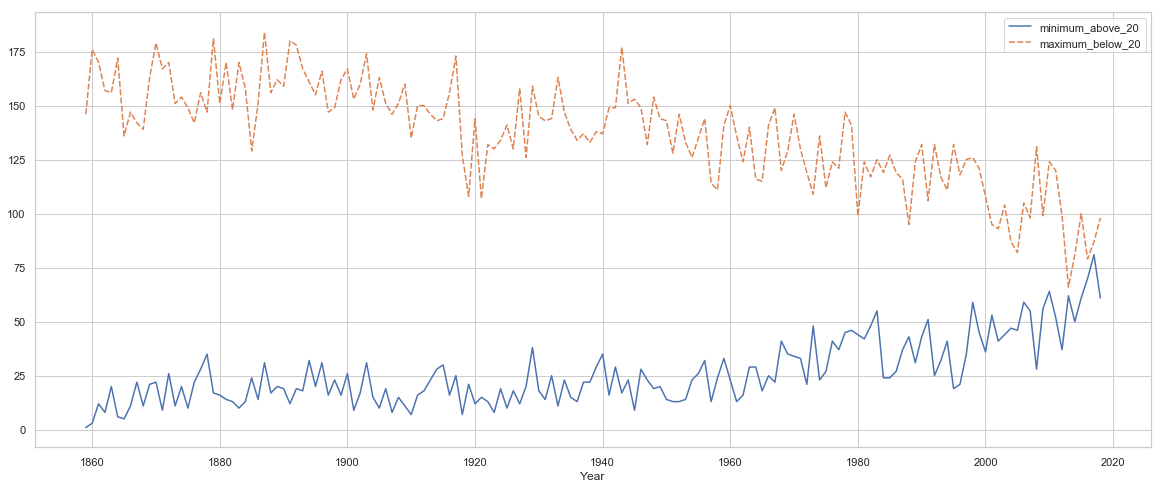

In [9]:
matplotlib.pyplot.figure(figsize=(20,8))
seaborn.lineplot(data=sydney_extremes)

So is Sydney becoming the city of endless Summer? 

- Who wants to take a bet on the first year when there are more summer-like days than winter-like days? 

- When do you think the chart below is going to hit 0?

I'm guessing around 2020.

We'll declare Sydney the **city of summer** from 2020 onwards.

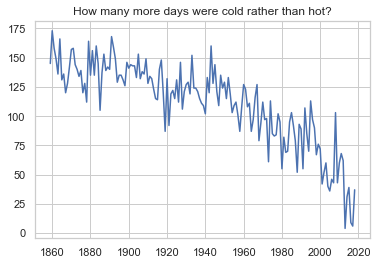

In [20]:
summer_vs_winter = sydney_extremes.maximum_below_20 - sydney_extremes.minimum_above_20
seaborn.lineplot(data=summer_vs_winter)
matplotlib.pyplot.title("How many more days were cold rather than hot?")
None

But let's not be hasty -- what does the post world-war 2 trend look like?

A RANSAC regressor (used because of the noisy signal) suggests around 2050.

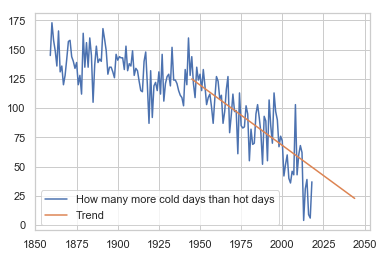

In [68]:
import sklearn.linear_model
predictor = sklearn.linear_model.RANSACRegressor()
post_1945 = summer_vs_winter[summer_vs_winter.index > 1945]
predictor.fit(post_1945.reset_index()[['Year']], post_1945)

prediction_range = list(range(1945, 2045))
chart_df = pd.DataFrame({
    'How many more cold days than hot days' : summer_vs_winter,
    'Trend': pd.Series(index=prediction_range, data=predictor.predict([[x] for x in prediction_range]))
})
chart_df.plot()

## Melbourne

Weather data from Melbourne is surprisingly bad. The longest run I can find is from 
Laverton RAAF base. (Weather station 087031)

- Maximum http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_display_type=dailyZippedDataFile&p_stn_num=087031&p_c=-1515112195&p_nccObsCode=122&p_startYear=2018

- Minimum http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_display_type=dailyZippedDataFile&p_stn_num=087031&p_c=-1515112391&p_nccObsCode=123&p_startYear=2018

The earliest full year with minimums and maximums is 1947.

Melbourne is 1000km closer to Antarctica than Sydney. For Melbourne to stay above 15 degrees even through
the night means something odd is happening.

In [11]:
MELBOURNE_MAX = 'IDCJAC0010_087031_1800'
MELBOURNE_MIN = 'IDCJAC0011_087031_1800'

melbourne_temperatures = get_temperature_ranges(MELBOURNE_MAX, MELBOURNE_MIN)
melbourne_temperatures = melbourne_temperatures[melbourne_temperatures.Year >= 1947]
melbourne_extremes = get_cold_and_hot_days(melbourne_temperatures, 15)

It's happening are more often now, though.

And if there are spring and autumn days above 15 degrees, something's wrong.

In [12]:
melbourne_extremes.loc[melbourne_extremes.index.isin([1947, last_full_year-50, last_full_year-100,
                                         last_full_year, last_full_year-1, last_full_year-2])]

,minimum_above_15,maximum_below_15
Year,,
1947,30,95
1968,43,99
2016,74,72
2017,66,69
2018,64,72


Here's the trend for Melbourne.

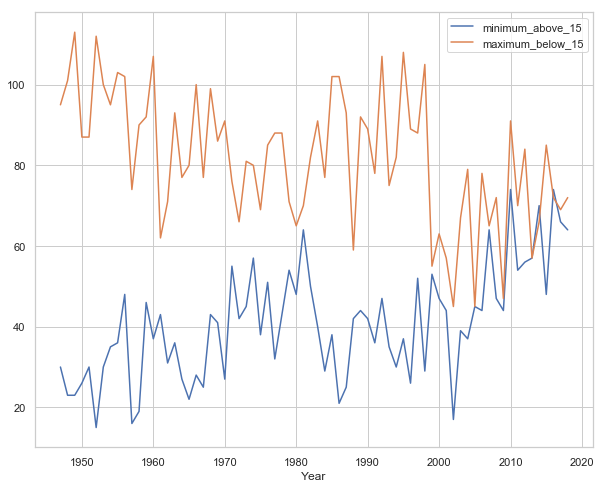

In [13]:
melbourne_extremes.plot(figsize=(10,8))

Even if we use the same threshold as Sydney, there's still a bit of a visible trend where
Melbourne is trying to turn into Sydney. It's a bit clearer with rolling average -- you
can see that around the year 2000 that cool days (the orange line) are getting rarer.

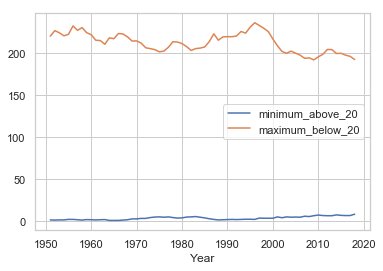

In [14]:
melbourne_extremes20 = get_cold_and_hot_days(melbourne_temperatures, threshold=20)
melbourne_extremes20.rolling(5).mean().plot()

## Brisbane

The Cape Morton lighthouse (station 040043) is about 60km away from Brisbane, so this won't quite reflect what
the residents of Brisbane experience, but it does show the trend. It's also the longest record of temperatures
around Brisbane, dating back to 1910. They look pretty surprising until 1920 though.

- Minimums: http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_display_type=dailyZippedDataFile&p_stn_num=040043&p_c=-320921768&p_nccObsCode=123&p_startYear=2018

- Maximums: http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_display_type=dailyZippedDataFile&p_stn_num=040043&p_c=-320921572&p_nccObsCode=122&p_startYear=2018

In [15]:
BRISBANE_MAX = 'IDCJAC0010_040043_1800'
BRISBANE_MIN = 'IDCJAC0011_040043_1800'

brisbane_temperatures = get_temperature_ranges(BRISBANE_MAX, BRISBANE_MIN)
brisbane_extremes = get_cold_and_hot_days(brisbane_temperatures, 20)

Still sticking with the 20 degree threshold... one hundred years ago it was twice as common
to have a below 20-degree day in Brisbane. 

In [16]:
brisbane_extremes.loc[brisbane_extremes.index.isin([last_full_year-50, last_full_year-100, 1859,
                                         last_full_year, last_full_year-1, last_full_year-2])]

,minimum_above_20,maximum_below_20
Year,,
1918,107,68
1968,119,71
2016,183,31
2017,162,24
2018,134,36


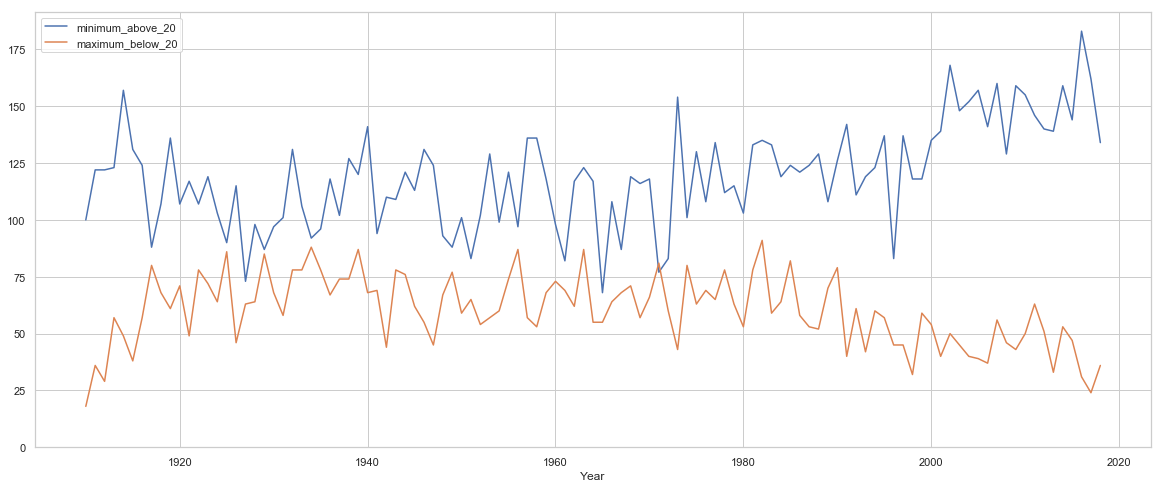

In [17]:
brisbane_extremes.plot(figsize=(20,8), ylim=0)